In [1]:
#!/usr/bin/env python
%matplotlib inline
import logging
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import pickle
import random
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense,Input, BatchNormalization,Activation
from keras.models import Sequential, Model
from keras.optimizers import Adam,RMSprop
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
from keras.initializers import TruncatedNormal
from keras.regularizers import  l2,l1_l2,l1
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
import bob.measure

/Users/gltest/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [17]:
class SoftmaxClassifier():
    def __init__(self,classfier_filename, data_dir,weight_regularization = False,early_return = False):
        self.classifier_filename = classfier_filename
        self.lb = LabelBinarizer()
        self.batch_num = 128
        self.thres = 1.0
        self.data_dir = data_dir
        self.weight_regularization = weight_regularization
        self.early_return = early_return
        K.set_image_data_format('channels_last')

    def prepare(self):
        labels = np.load(os.path.join(self.data_dir, 'labels.npy'))
        self.train_codes = np.load(os.path.join(self.data_dir, 'train_codes.npy'))
        self.test_codes = np.load(os.path.join(self.data_dir, 'test_codes.npy'))
        self.train_labels = np.squeeze(np.load(os.path.join(self.data_dir, 'train_labels.npy')))
        self.test_labels = np.squeeze(np.load(os.path.join(self.data_dir, 'test_labels.npy')))
        self.test_idcs = np.load(os.path.join(self.data_dir,'test_labels_idcs.npy'))
        self.random_draw_codes = np.load(os.path.join(self.data_dir, 'random_draw_codes.npy'))
        self.random_draw_label = np.squeeze(np.load(os.path.join(self.data_dir, 'random_draw_labels.npy')))

        ## label to binarized codes
        self.lb.fit(np.squeeze(labels))
        self.trm_test_labels = self.lb.transform(self.test_labels)
        self.trm_train_labels = self.lb.transform(self.train_labels)

        ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        train_idcs, val_idcs = next(ss.split(self.train_codes, self.trm_train_labels))
        self.x_codes = self.train_codes[train_idcs]
        self.y_labels = self.trm_train_labels[train_idcs]
        self.val_codes = self.train_codes[val_idcs]
        self.val_labels = self.trm_train_labels[val_idcs]

        # classifier
        logger.info("train codes shape {}".format(self.x_codes.shape))
        logger.info("validation codes shape {}".format(self.val_codes.shape))
        logger.info("train label shape {}".format(self.y_labels.shape))
        logger.info("validation label shape {}".format(self.val_labels.shape))

        self.model = Sequential()
        self.model.add(GlobalAveragePooling2D(name='global_average', input_shape=self.x_codes.shape[1:]))
        if self.weight_regularization == True:
            self.model.add(Dense(len(np.unique(self.test_labels)),
                             activation='softmax', name='prediction1',
                            kernel_initializer= TruncatedNormal(stddev=0.05),kernel_regularizer=l2(0.001)))
        else:
            self.model.add(Dense(len(np.unique(self.test_labels)),
                             activation='softmax', name='prediction2'))
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                           metrics=['accuracy'])

        self.model.summary()

    def train(self):

        ## split training set further for training and validation set

        start_time = time.time()
        logger.info('Training starts...' )
        checkpointer = ModelCheckpoint(filepath=self.classifier_filename,
                                       verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(patience=20)
        tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True,
                                                 write_images=True,write_grads=True)
        tbCallBack.set_model(self.model)

        if self.early_return == True:
            evaluation = self.model.fit(self.x_codes, self.y_labels,
                            validation_data=(self.val_codes, self.val_labels),
                            epochs=1000, batch_size=self.batch_num, callbacks=[checkpointer,tbCallBack,early_stopping], verbose=1)
        else:
            evaluation = self.model.fit(self.x_codes, self.y_labels,
                            validation_data=(self.val_codes, self.val_labels),
                            epochs=1000, batch_size=self.batch_num, callbacks=[checkpointer,tbCallBack], verbose=1)
        logger.info('Completed in {} seconds'.format(time.time() - start_time))
        logger.info("Training result {}".format(evaluation))
        pickle.dump(evaluation.history, open("../model/soft_max_train_history.pickle", "wb"))
        return evaluation

    def train_history_visual(self):

        # summarize history for accuracy
        with open("../model/soft_max_train_history.pickle", 'rb') as pickle_file:
            history = pickle.load(pickle_file)
        plt.figure(figsize=(8,4))
        plt.subplot(1, 2, 1)
        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='lower right')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

    def predict(self, test_codes):
        predicts = []
        self.model.load_weights(self.classifier_filename)
        predict_probs = self.model.predict_proba(test_codes)
        for idx in range(len(predict_probs)):
             if predict_probs[idx].max()>= self.thres:  ## need to be optimized
                 label = self.lb.inverse_transform( predict_probs[idx].reshape(
                                                                      (-1, len(predict_probs[idx]))),threshold=0.5)
                 predicts.append(np.asscalar(label))
             else:
                 #predicts.append(np.array([]))
                 predicts.append(-1)
        #return np.array(predicts)
        return predicts

    def determin_threshold(self):
        """
        :return:  determin threshold
        """
        self.model.load_weights(self.classifier_filename)
        predict_probs = self.model.predict_proba(self.val_codes)
        max_probs = predict_probs.max(axis=1)
        return max_probs.mean()


    def evaluation(self):
        true_accept = 0.0
        false_accept = 0.0
        true_reject = 0.0
        false_reject = 0.0

        negative_scores = []
        positive_scores = []

        self.thres = self.determin_threshold()
        logger.info("threshold {}".format(self.thres))
        logger.info("Testing all authorized labels...")
        predictions_thres = self.predict(self.test_codes)
        
        all_test = 0.0

            
        for test_id in range(len(self.test_labels)):
            if predictions_thres[test_id] != self.test_labels[test_id]:
                logger.info("data id  {} false rejected as label {}, true label {}"
                            .format(self.test_idcs[test_id], predictions_thres[test_id], self.test_labels[test_id]))
                false_reject += 1.0
            else:
                true_accept += 1.0
            all_test += 1.0

        TR = true_accept / all_test
        FR = false_reject / all_test

        logger.info("true_acceptance: {0:.4f}".format(TR))
        logger.info("false_rejection: {0:.4f}".format(FR))

        # analysis

        logger.info("Testing random draw labels...")

        # not in the system
        predictions_thres = self.predict(self.random_draw_codes)

        true_accept = 0.0
        false_accept = 0.0
        true_reject = 0.0
        false_reject = 0.0
        all_test = 0.0
        # what went wrong
        for test_id in range(len(self.random_draw_codes)):
            if (self.random_draw_label[test_id] == self.train_labels).any() == True:
                # in the system
                if predictions_thres[test_id] != self.random_draw_label[test_id]:
                    false_reject += 1.0
                    logger.info("data id  {} false rejected as label {}, true label {}"
                                .format(test_id, predictions_thres[test_id], self.random_draw_label[test_id]))
                else:
                    true_accept += 1.0
                    logger.info("data id  {} accepted label  {} true label {} "
                                .format(test_id, predictions_thres[test_id], self.random_draw_label[test_id]))
            else:
                # not in the system
                if predictions_thres[test_id]!=-1:
                    false_accept += 1.0
                    logger.info("data id  {} false accepted as label {}, none autherized label {}"
                                .format(test_id, predictions_thres[test_id], self.random_draw_label[test_id]))
                else:
                    true_reject += 1.0
                    logger.info("data id  {} rejected label {}, none autherized"
                                .format(test_id, self.random_draw_label[test_id]))
            all_test += 1.0



        FAR = false_accept / all_test
        TR = true_reject/all_test
        logger.info("true_rejection: {0:.4f}".format(TR))
        logger.info("false_acceptance: {0:.4f}".format(FAR))

    def Alejandro_Toledo_match_visual(self):
        # its label is 128
        Alejandro_Toledo_idcs = np.where(self.test_labels == 128)[0]

        df = pd.read_csv(os.path.join(self.data_dir,"lfw_dataset.csv"),names=['id','label','name','path'])
        predicted_name = []
        predicted_image_path = []
        true_image_path = []

        for i in range(len(Alejandro_Toledo_idcs)):
            test_codes = self.test_codes[Alejandro_Toledo_idcs[i]]
            predicted_label = self.predict(test_codes[None,:])[0]
            data_id = self.test_idcs[Alejandro_Toledo_idcs[i]]
            #print("predicted_label:",predicted_label)
            if predicted_label != 128 and predicted_label != -1:
                predicted_name.append(df[df['label']== str(predicted_label)]['name'].values[0])
                true_image_path.append(df.iloc[data_id]['path'].strip())
                predicted_image_path.append(df[df['label']== str(predicted_label)]['path'].values[0])

        fig = plt.figure(figsize=(8, 6))
        for i in range(len(predicted_image_path)):
            ax = fig.add_subplot(len(predicted_image_path),2, 2*i + 1, xticks=[], yticks=[])
            img = mpimg.imread(true_image_path[i].strip())
            ax.imshow(img)
            ax = fig.add_subplot(len(predicted_image_path),2, 2*i + 2, xticks=[], yticks=[])
            img = mpimg.imread(predicted_image_path[i].strip())
            ax.imshow(img)
            ax.set_title("predicted as {}".format(predicted_name[i]),
                color=("green" if predicted_name[i] == 'Alejandro_Toledo' else "red")) 
        plt.show()

In [18]:
clr = SoftmaxClassifier(classfier_filename='../model/weights_soft_max_jupyter.hdf5',
                        data_dir='../data/cropped_20',weight_regularization = True, early_return = False)
clr.prepare()

INFO:__main__:train codes shape (1520, 1, 1, 2048)
INFO:__main__:validation codes shape (381, 1, 1, 2048)
INFO:__main__:train label shape (1520, 62)
INFO:__main__:validation label shape (381, 62)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average (GlobalAverag (None, 2048)              0         
_________________________________________________________________
prediction1 (Dense)          (None, 62)                127038    
Total params: 127,038
Trainable params: 127,038
Non-trainable params: 0
_________________________________________________________________


In [5]:
evaluation1 = clr.train()

INFO:__main__:Training starts...


Train on 1520 samples, validate on 381 samples
Epoch 1/1000
1152/1520 [=====================>........] - ETA: 0s - loss: 4.7940 - acc: 0.0469
Epoch 00001: val_loss improved from inf to 4.18935, saving model to ../model/weights_soft_max_jupyter.hdf5
1520/1520 [==============================] - 0s 295us/step - loss: 4.7248 - acc: 0.0507 - val_loss: 4.1893 - val_acc: 0.0709
Epoch 2/1000
1152/1520 [=====================>........] - ETA: 0s - loss: 3.8865 - acc: 0.1398
Epoch 00002: val_loss improved from 4.18935 to 3.65692, saving model to ../model/weights_soft_max_jupyter.hdf5
1520/1520 [==============================] - 0s 212us/step - loss: 3.8320 - acc: 0.1520 - val_loss: 3.6569 - val_acc: 0.1785
Epoch 3/1000
1152/1520 [=====================>........] - ETA: 0s - loss: 3.2648 - acc: 0.2839

INFO:__main__:Completed in 399.4097309112549 seconds
INFO:__main__:Training result <keras.callbacks.History object at 0x12bbd0f60>


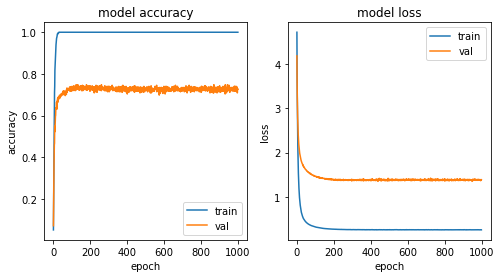

INFO:__main__:threshold 0.6512181162834167
INFO:__main__:Testing all authorized labels...
INFO:__main__:data id  247 false rejected as label -1, true label 386
INFO:__main__:data id  1768 false rejected as label -1, true label 3738
INFO:__main__:data id  2 false rejected as label -1, true label 128
INFO:__main__:data id  248 false rejected as label -1, true label 386
INFO:__main__:data id  984 false rejected as label -1, true label 2176
INFO:__main__:data id  2082 false rejected as label -1, true label 5040
INFO:__main__:data id  1522 false rejected as label -1, true label 3128
INFO:__main__:data id  282 false rejected as label -1, true label 418
INFO:__main__:data id  89 false rejected as label -1, true label 224
INFO:__main__:data id  1131 false rejected as label -1, true label 2469
INFO:__main__:data id  1115 false rejected as label -1, true label 2289
INFO:__main__:data id  669 false rejected as label -1, true label 1872
INFO:__main__:data id  376 false rejected as label -1, true l

In [20]:
clr.train_history_visual()
clr.evaluation()

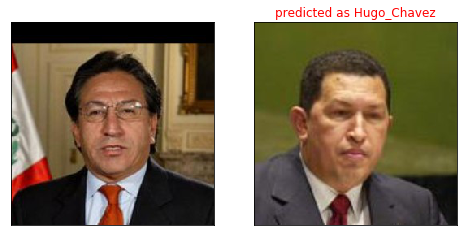

In [21]:
clr.Alejandro_Toledo_match_visual()